## Install Packages

In [1]:
# pyspark

!pip install pyspark

In [2]:
!pip install -U textblob

In [3]:
!pip install tensorflow

In [4]:
!pip install gensim

In [5]:
!pip install wordcloud

In [6]:
!pip install plotly

In [7]:
!pip install statsmodels

In [8]:
!pip install scikit-learn

In [9]:
!pip install statsmodels

## Import Libraries

In [10]:
################################################### spark #################################################################

from pyspark.sql import SparkSession

################################################### base #################################################################

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

################################################### nlp #################################################################

import numpy as np

import gensim
import nltk
import re
from nltk.sentiment import SentimentIntensityAnalyzer
from textblob import TextBlob
from wordcloud import WordCloud, STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize.treebank import TreebankWordDetokenizer

################################################### time series #################################################################



from statsmodels.tsa.seasonal import seasonal_decompose
from nltk.corpus import stopwords as nltk_stopwords

###################################################  ml #################################################################

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional,Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

################################################# confusion matrix #################################################################

from sklearn.metrics import confusion_matrix

## Viewing Data

In [121]:
def load_and_process_data(spark, hdfs_path):
    try:
        # Read the CSV file into a DataFrame
        data = spark.read.option("header", "true").csv(hdfs_path)

        # Check if the data was loaded successfully
        if data is not None:
            # Define new column names
            new_column_names = ["number", "id_tweet", "date", "query", "user_id", "tweet"]

            # Rename the columns using the alias method
            for i in range(len(new_column_names)):
                data = data.withColumnRenamed(data.columns[i], new_column_names[i])

            # Create a temporary view from the DataFrame
            data.createOrReplaceTempView("CA2_ProjectTweets")

            # Run Spark SQL queries using the same SparkSession
            result = spark.sql("SELECT * FROM CA2_ProjectTweets")

            # Display the first 5 rows
            result.show(5)

            return result
        else:
            print("Data not loaded successfully.")
            return None

    except Exception as e:
        print("An error occurred:", str(e))
        return None




## Create Spark

In [122]:
from pyspark.sql import SparkSession

# Create a Spark session
spark = SparkSession.builder.appName('ProjectTweets').getOrCreate()

# Specify the HDFS path to your CSV file
hdfs_path = "/content/ProjectTweets.csv"

# Call the function and get the result
tweets = load_and_process_data(spark, hdfs_path)

# Check if the result is not None before attempting further operations
if tweets is not None:
    # You can perform additional operations on the result DataFrame if needed
    # For example, you can continue processing the data or perform analysis

    # Display the schema of the DataFrame
    tweets.printSchema()

    # Perform additional operations or analysis as needed
    # ...

    # Stop the Spark session when done
    spark.stop()
else:
    print("Data loading and processing failed.")


+------+----------+--------------------+--------+-------------+--------------------+
|number|  id_tweet|                date|   query|      user_id|               tweet|
+------+----------+--------------------+--------+-------------+--------------------+
|     1|1467810672|Mon Apr 06 22:19:...|NO_QUERY|scotthamilton|is upset that he ...|
|     2|1467810917|Mon Apr 06 22:19:...|NO_QUERY|     mattycus|@Kenichan I dived...|
|     3|1467811184|Mon Apr 06 22:19:...|NO_QUERY|      ElleCTF|my whole body fee...|
|     4|1467811193|Mon Apr 06 22:19:...|NO_QUERY|       Karoli|@nationwideclass ...|
|     5|1467811372|Mon Apr 06 22:20:...|NO_QUERY|     joy_wolf|@Kwesidei not the...|
+------+----------+--------------------+--------+-------------+--------------------+
only showing top 5 rows

root
 |-- number: string (nullable = true)
 |-- id_tweet: string (nullable = true)
 |-- date: string (nullable = true)
 |-- query: string (nullable = true)
 |-- user_id: string (nullable = true)
 |-- tweet: str

## Show Column Names

In [128]:
tweets.columns

['number', 'id_tweet', 'date', 'query', 'user_id', 'tweet']

## Show Schema

In [98]:
tweets.printSchema()

root
 |-- number: string (nullable = true)
 |-- id_tweet: string (nullable = true)
 |-- date: string (nullable = true)
 |-- query: string (nullable = true)
 |-- user_id: string (nullable = true)
 |-- tweet: string (nullable = true)



## Show Dtypes

In [99]:
tweets.dtypes

[('number', 'string'),
 ('id_tweet', 'string'),
 ('date', 'string'),
 ('query', 'string'),
 ('user_id', 'string'),
 ('tweet', 'string')]

## Cast Column Type and convert

In [84]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.sql.types import IntegerType, FloatType, DateType

In [86]:

# Convert columns to the desired data types
tweets = tweets.withColumn("number", tweets["number"].cast(IntegerType()))
tweets = tweets.withColumn("id_tweet", tweets["id_tweet"].cast(FloatType()))
tweets = tweets.withColumn("date", tweets["date"].cast(DateType()))



In [90]:
tweets.dtypes

[('number', 'int'),
 ('id_tweet', 'float'),
 ('date', 'date'),
 ('query', 'string'),
 ('user_id', 'string'),
 ('tweet', 'string')]

## Convert PySpark DataFrame to Pandas

In [125]:
import pandas as pd

In [136]:
#read dataset
project_tweets = pd.read_csv("ProjectTweets.csv", encoding = 'latin', header=None)


In [137]:
project_tweets = project_tweets.rename(columns={0: 'number', 1: 'id', 2: 'date', 3: 'query', 4: 'username', 5: 'tweets'})

## Head

In [138]:
project_tweets.head()

,number,id,date,query,username,tweets
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,1,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,2,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,3,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,4,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


## Tail

In [142]:
project_tweets.tail()

,number,id,date,query,username,tweets
1599995,1599995,2193601966,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,AmandaMarie1028,Just woke up. Having no school is the best fee...
1599996,1599996,2193601969,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,TheWDBoards,TheWDB.com - Very cool to hear old Walt interv...
1599997,1599997,2193601991,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,bpbabe,Are you ready for your MoJo Makeover? Ask me f...
1599998,1599998,2193602064,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,tinydiamondz,Happy 38th Birthday to my boo of alll time!!! ...
1599999,1599999,2193602129,Tue Jun 16 08:40:50 PDT 2009,NO_QUERY,RyanTrevMorris,happy #charitytuesday @theNSPCC @SparksCharity...


## Information

In [141]:
project_tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column    Non-Null Count    Dtype 
---  ------    --------------    ----- 
 0   number    1600000 non-null  int64 
 1   id        1600000 non-null  int64 
 2   date      1600000 non-null  object
 3   query     1600000 non-null  object
 4   username  1600000 non-null  object
 5   tweets    1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


## Cheking Missing Values

In [144]:
project_tweets.isna().sum()

number      0
id          0
date        0
query       0
username    0
tweets      0
dtype: int64

## Shape

In [145]:
project_tweets.shape

(1600000, 6)

## Data Visualization

Length Tweets

<Axes: >

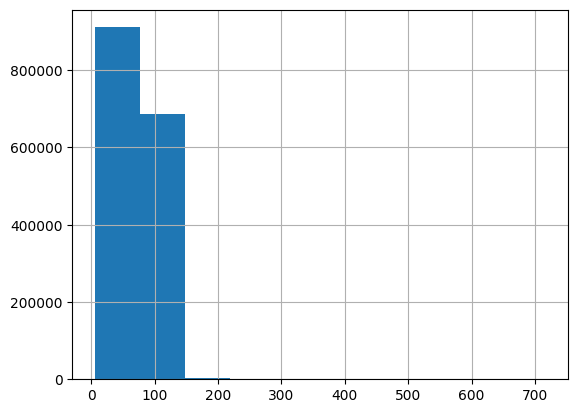

In [146]:
project_tweets['tweets'].str.len().hist()

Mean Tweets

<Axes: >

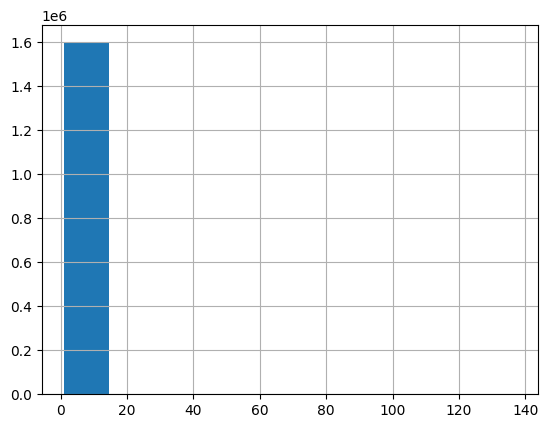

In [147]:
project_tweets['tweets'].str.split().apply(lambda x : [len(i) for i in x]).map(lambda x: np.mean(x)).hist()

In [148]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

stop = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [149]:
def plot_top_stopwords_barchart(tweets):
    stop=set(stopwords.words('english'))

    new= tweets.str.split()
    new=new.values.tolist()
    corpus=[word for i in new for word in i]
    from collections import defaultdict
    dic=defaultdict(int)
    for word in corpus:
        if word in stop:
            dic[word]+=1

    top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10]
    x,y=zip(*top)
    plt.bar(x,y)

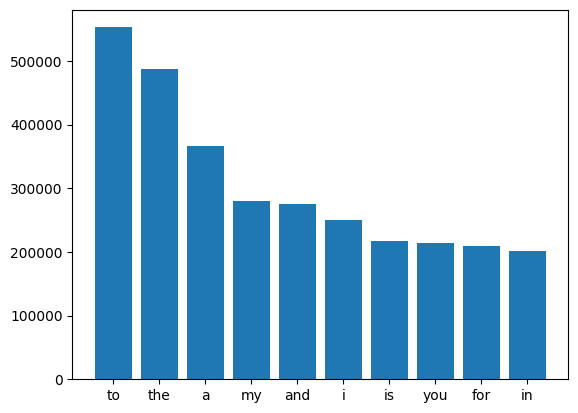

In [150]:
plot_top_stopwords_barchart(project_tweets['tweets'])

In [151]:
from nltk.corpus import stopwords
from collections import  Counter

In [152]:
def plot_top_non_stopwords_barchart(text):
    stop=set(stopwords.words('english'))

    new= text.str.split()
    new=new.values.tolist()
    corpus=[word for i in new for word in i]

    counter=Counter(corpus)
    most=counter.most_common()
    x, y=[], []
    for word,count in most[:40]:
        if (word not in stop):
            x.append(word)
            y.append(count)

    sns.barplot(x=y,y=x)

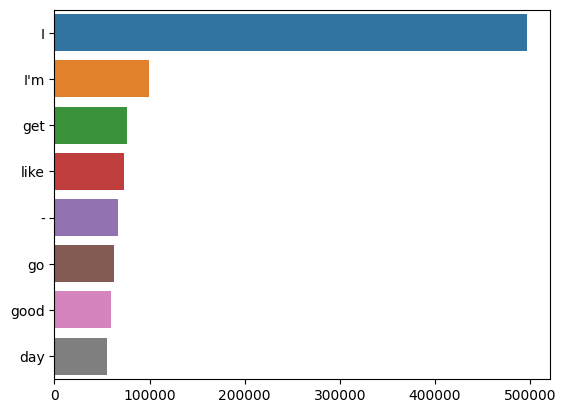

In [153]:
plot_top_non_stopwords_barchart(project_tweets['tweets'])

## World Cloud

In [154]:
# word cloud

#Make a word Cloud from dataset
stopwords = set(STOPWORDS)

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=50,
        max_font_size=40,
        scale=5,
        random_state=1
    ).generate(str(data))

    fig = plt.figure(1, figsize=(10,10))
    plt.axis('off')
    if title:
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

In [155]:
def show_wordcloud(data, title=""):
    text = " ".join(t for t in data.dropna())
    stopwords = set(STOPWORDS)
    stopwords.update(["t", "co", "https", "amp", "U"])
    wordcloud = WordCloud(stopwords=stopwords, scale=4, max_font_size=40, max_words=700,background_color="#002210").generate(text)
    fig = plt.figure(1, figsize=(20,20))
    plt.axis('off')
    fig.suptitle(title, fontsize=20)
    fig.subplots_adjust(top=2.3)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.style.use('ggplot')
    plt.show()

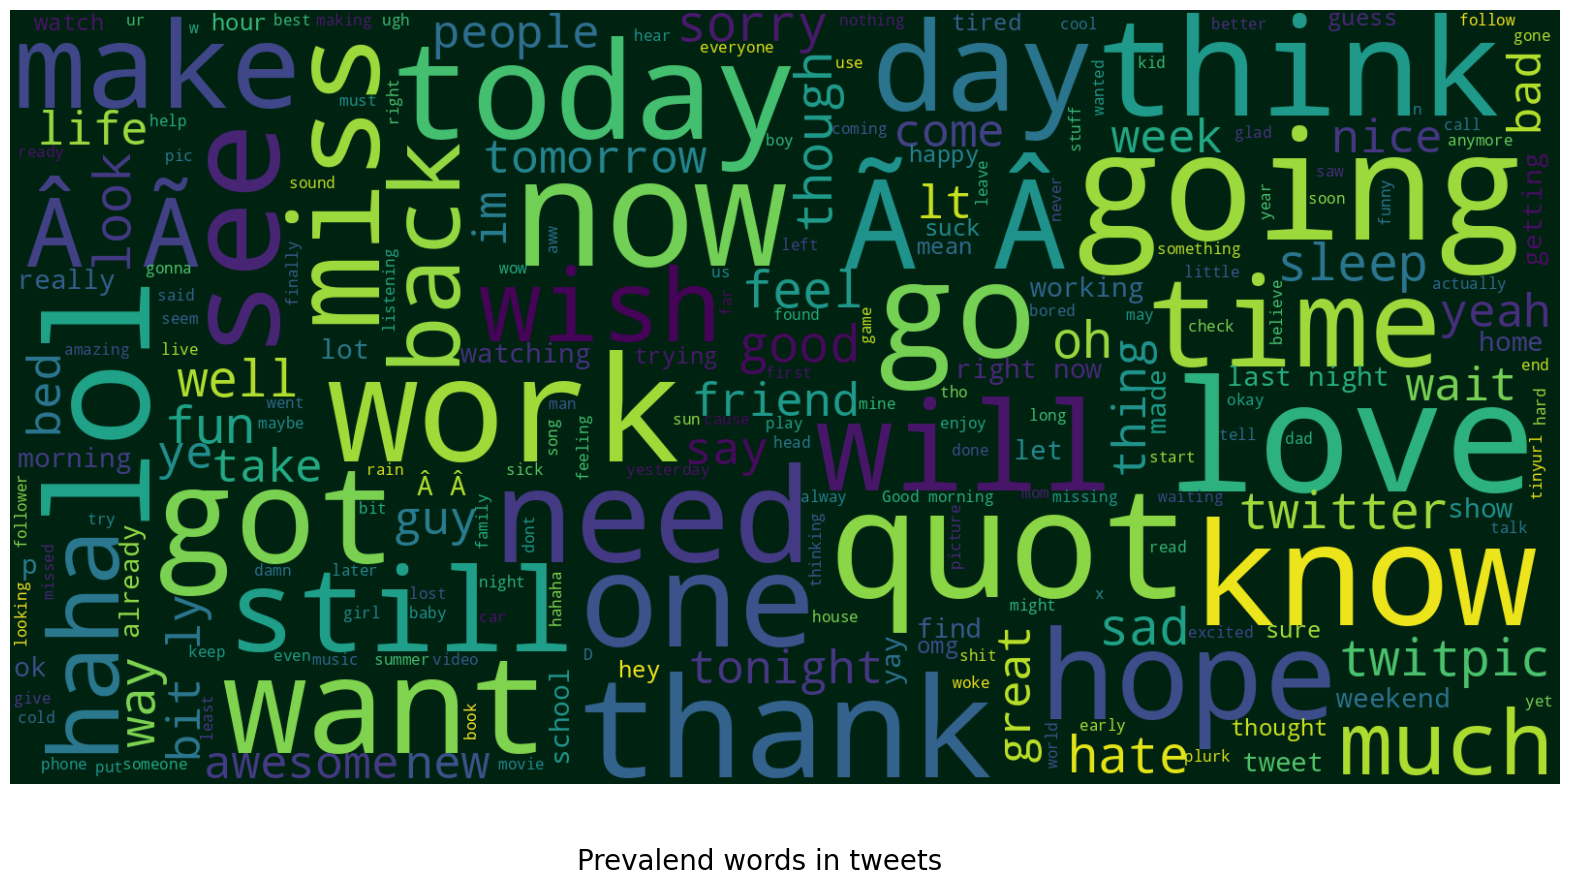

In [156]:
show_wordcloud(project_tweets['tweets'] , title = 'Prevalend words in tweets')

## Hastag Analysis

Top 5 Hashtags:
#followfriday: 2288
#fb: 1765
#squarespace: 867
#ff: 822
#seb-day: 498


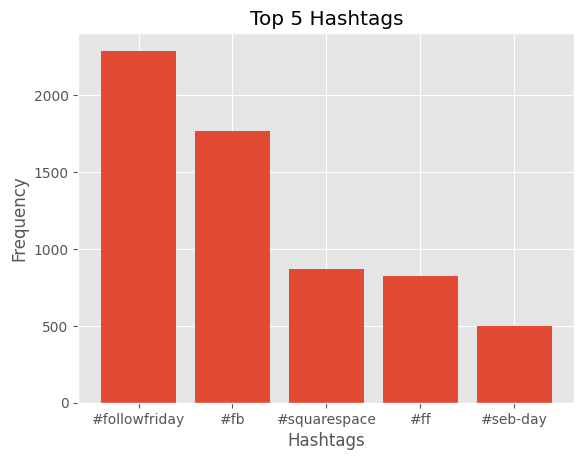

In [158]:
# Extract hashtags from the 'text' column
def extract_hashtags_from_text(text):
    words = text.split()
    return [word.lower() for word in words if word.startswith("#")]

# Apply the function to the 'text' column
project_tweets['hashtags'] = project_tweets['tweets'].apply(extract_hashtags_from_text)

# Flatten the list of hashtags
all_hashtags = [tag for sublist in project_tweets['hashtags'].tolist() for tag in sublist]

# Analyze and plot hashtag frequencies
top_n = 5
hashtag_counts = Counter(all_hashtags)
top_hashtags = dict(hashtag_counts.most_common(top_n))

# Display the list of hashtags and their frequencies
print("Top {} Hashtags:".format(top_n))
for hashtag, frequency in top_hashtags.items():
    print(f"{hashtag}: {frequency}")

# Plot the hashtag frequencies
plt.bar(top_hashtags.keys(), top_hashtags.values())
plt.xlabel('Hashtags')
plt.ylabel('Frequency')
plt.title('Top {} Hashtags'.format(top_n))
plt.show()